# Visualizing embedding similarities

In [3]:
# import everything
from collections import namedtuple
from r3meval.utils.gym_env import GymEnv
from r3meval.utils.obs_wrappers import MuJoCoPixelObs, StateEmbedding
from r3meval.utils.sampling import sample_paths
from r3meval.utils.gaussian_mlp import MLP
from r3meval.utils.behavior_cloning import BC
from tabulate import tabulate
from tqdm import tqdm
import mj_envs, gym
import numpy as np, time as timer, multiprocessing, pickle, os
import os
from collections import namedtuple
import metaworld
from metaworld.envs import (ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE,
                            ALL_V2_ENVIRONMENTS_GOAL_HIDDEN)

/sailhome/kayburns/anaconda3/envs/py3.8_torch1.10.1/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/sailhome/kayburns/anaconda3/envs/py3.8_torch1.10.1/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


RS:> Registering Arms Envs
RS:> Registering Biomechanics Envs
RS:> Registering Hand Envs
RS:> Registering Kitchen Envs


In [37]:
# code to load in and visualize environment underneath different distribution shifts
def initial_image_generation(env_name, model_path, device='cuda', image_width=256, image_height=256, camera_name="right_cap2", embedding_name='resnet50', pixel_based=True,
                    render_gpu_id=0, load_path="", proprio=False, lang_cond=False, gc=False):
    """Takes in env_name and model_path to generate image of initial env."""
    ## If pixel based will wrap in a pixel observation wrapper
    if pixel_based:
        ## Need to do some special environment config for the metaworld environments
        if "v2" in env_name:
            e  = ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE[env_name]()
            e._freeze_rand_vec = False
            e.spec = namedtuple('spec', ['id', 'max_episode_steps'])
            e.spec.id = env_name
            e.spec.max_episode_steps = 500
        else:
            e = gym.make(env_name, model_path = model_path)
        ## Wrap in pixel observation wrapper
        e = MuJoCoPixelObs(e, width=image_width, height=image_height,
                           camera_name=camera_name, device_id=render_gpu_id)
        ## Wrapper which encodes state in pretrained model
        e = StateEmbedding(e, embedding_name=embedding_name, device=device, load_path=load_path,
                        proprio=proprio, camera_name=camera_name, env_name=env_name)
        e = GymEnv(e)
    else:
        print("Only supports pixel based")
        assert(False)
    # import pdb;pdb.set_trace()
    from PIL import Image
    im = e.env.get_image()
    image = Image.fromarray(im)
    return e, image

In [27]:
# fetch all franka kitchen shift xmls
xml_path = "/iris/u/kayburns/packages/mj_envs/mj_envs/envs/relay_kitchen/assets/"
shift_xmls = os.listdir(xml_path)
shift_xmls = [xml for xml in shift_xmls if 'franka_kitchen' in xml]

In [43]:
e1, image1 = initial_image_generation('kitchen_sdoor_open-v3',  os.path.join(xml_path, shift_xmls[4]), embedding_name='resnet50')
e2, image2 = initial_image_generation('kitchen_sdoor_open-v3',  os.path.join(xml_path, shift_xmls[5]), embedding_name='resnet50')

/sailhome/kayburns/anaconda3/envs/py3.8_torch1.10.1/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Using CUDA.
Using CUDA.


franka_kitchen_slide_tile1.xml


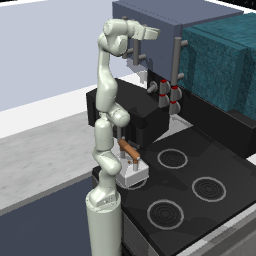

In [44]:
print(shift_xmls[4])
image1

franka_kitchen_slide_tile1.xml


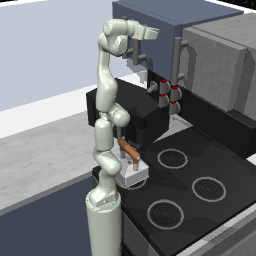

In [45]:
print(shift_xmls[4])
image2

In [49]:
representation_1 = e1.reset()
representation_2 = e2.reset()

shifting input to 0-255 (should only happen for R3M)
shifting input to 0-255 (should only happen for R3M)


In [50]:
((representation_1 - representation_2)**2).mean() # change to be normalized

816.9138